Exploring a sample of the [SEN12MS dataset](https://arxiv.org/abs/1906.07789). The code for the data loader is provided by the authors of the paper and the dataset. We only explore the functionality they implemented and look through some of the images.

In [1]:
# in Colab, rasterio needs to be installed
# !pip install rasterio

import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch

# download and extract the dataset sample (I uploaded it to my GDrive)
if not pathlib.Path('../SEN12MS_sample').is_dir():
    !gdown --id 1GKHIPhhfjutCbb3LhJ0tgjxDvIuDO7tr
    !tar -zxf SEN12MS_sample.tgz
    !rm SEN12MS_sample.tgz
sys.path.insert(1,"../")
# this module comes with the dataset and it provides a data loader
import SEN12MS_sample.sen12ms_dataLoader as sen12ms
sys.path.remove("../")

In [2]:
# initialize the data loader
dataset = sen12ms.SEN12MSDataset(base_dir='../SEN12MS_sample')

In [3]:
def get_false_color_s1_image(s1_data):
    """ Generate a VV/VH/R false color image to plot with matplotlib. """
    
    # add a polarization ratio channel
    image = np.empty(shape=(3,) + s1_data.shape[1:])  # new shape is (3, H, W)
    image[:2, ...] = s1_data                          # the first two channels are the same
    image[2] = s1_data[0] - s1_data[1]                # the data is in dB, so ratio becomes difference

    # normalize channel-wise and swap axes from CHW to HWC
    shifted = image - image.min(axis=(1, 2), keepdims=True)
    spread = image.max(axis=(1, 2), keepdims=True) - image.min(axis=(1, 2), keepdims=True)
    
    image = np.transpose(shifted / spread, [1, 2, 0])
    
    return image

In [17]:
# get data
season = sen12ms.Seasons.SUMMER
scene = next(iter(dataset.get_scene_ids(season)))
patch_ids = dataset.get_patch_ids(season, scene)

sample_patches = random.sample(patch_ids, 3)
sample_patches = [523, 511, 427]
print(sample_patches)
kwargs = {
    'season': season,
    'scene_ids': scene,
    'patch_ids': sample_patches,
    's1_bands': sen12ms.S1Bands.ALL,
    's2_bands': sen12ms.S2Bands.ALL,
    'lc_bands': sen12ms.LCBands.ALL,
}

s1, s2, lc, _ = dataset.get_triplets(**kwargs)


[523, 511, 427]


In [18]:
# ----------------------------------------
# load model
# ----------------------------------------
from models.network_unet import UNetRes as net

model_pool = 'model_zoo'             # fixed
model_name = 'drunet_color'  # set denoiser model, 'drunet_gray' | 'drunet_color'
model_path = os.path.join(model_pool, model_name+'.pth')

n_channels = 1                       # 1 for grayscale image
if 'color' in model_name:
    n_channels = 3                   # 3 for color image
task_current = 'dn'                  # 'dn' for denoising

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

model = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
for k, v in model.named_parameters():
    v.requires_grad = False
model = model.to(device)
print('Model path: {:s}'.format(model_path))
number_parameters = sum(map(lambda x: x.numel(), model.parameters()))
print('Params number: {}'.format(number_parameters))


Model path: model_zoo/drunet_color.pth
Params number: 32640960


In [19]:
# form batch to denose

noise_level_model = 70.

# print(f's1.shape: {s1.shape}\n')
# print(f's2.shape: {s2.shape}\n')
# print(f'lc.shape: {lc.shape}\n')

# Santinel-1
din = torch.tensor([get_false_color_s1_image(img) for img in s1],device=device, dtype = torch.float32)
din = din.permute([0,3,1,2])
# add random normal noise
din += torch.randn(din.shape,device=device,dtype = torch.float32)*noise_level_model/255.
# Add noise map
nose_map = torch.tensor([noise_level_model/255.],device=device, dtype = torch.float32).repeat(din.shape[0], 1, din.shape[2], din.shape[3])
din = torch.cat((din,nose_map), dim=1)


print(f'din.shape: {din.shape}\n')
# mono  din.shape: torch.Size([bs, 2, 256, 256])
# color din.shape: torch.Size([bs, 4, 256, 256])


din.shape: torch.Size([3, 4, 256, 256])



In [20]:
from utils import utils_model
denoised = model(din)
denoised = denoised.to('cpu').permute([0,2,3,1]).numpy()
denoised.shape

(3, 256, 256, 3)

Text(0.5, 1.0, 'Sentinel-2 True Color')

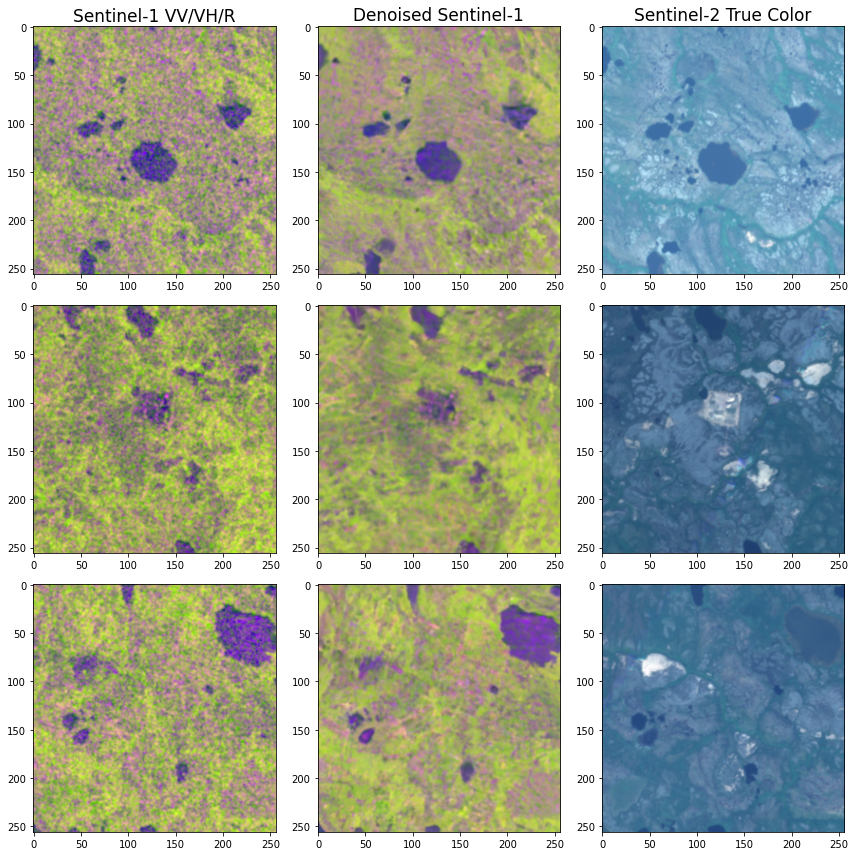

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), tight_layout=True)
for i in range(3):
    s1_image = get_false_color_s1_image(s1[i])
    rgb = s2[i, 3:0:-1]
    s2_image = np.transpose(rgb / rgb.max(axis=(1, 2), keepdims=True), [1, 2, 0])
#     lc_image = lc[i, 3]
    
    axes[i, 0].imshow(s1_image, aspect='auto', cmap='binary')
    axes[i, 1].imshow(denoised[i], aspect='auto')
    axes[i, 2].imshow(s2_image, aspect='auto')
#     axes[i, 2].imshow(lc_image.squeeze(), aspect='auto')

axes[0, 0].set_title('Sentinel-1 VV/VH/R', fontsize=17)
axes[0, 1].set_title('Denoised Sentinel-1', fontsize=17);
axes[0, 2].set_title('Sentinel-2 True Color', fontsize=17)
# axes[0, 2].set_title('Land cover (disapointing)', fontsize=17)

